Testing if GPU is enabled

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Importing the required dataset**

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "lakshmib21cs040"
os.environ['KAGGLE_KEY']= "776faf2cdf4b5b0aecec4539929e3adf"

In [ ]:
!kaggle datasets download tawsifurrahman/covid19-radiography-database

 99% 772M/778M [00:05<00:00, 101MB/s]
100% 778M/778M [00:05<00:00, 140MB/s]


In [ ]:
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# **Importing the required libraries**

In [ ]:
! pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd 
import numpy as np
import random 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from skimage import io
from sklearn.model_selection import train_test_split
import torch
import keras
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
import matplotlib.cm as cm
from torchvision import transforms
import plotly.express as px
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras.utils import plot_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# **Rendering a couple of images from each class**

In [ ]:
def show_images(disease):
  # Function to plot the 5 random X-ray images of the specified medical condition
  
  n_images = len(os.listdir(os.path.join('COVID-19_Radiography_Dataset',disease,'images')))   # gets the number of files in a particular directory
  images = []
  for i in range(5):
    r_num = random.randint(1,n_images)
    temp = disease + '-' + str(r_num) + '.png'
    img_path = os.path.join('COVID-19_Radiography_Dataset',disease,'images',temp)
    images.append(io.imread(img_path))

  fig, ax = plt.subplots(1, 5, figsize=(12, 8))
  ax = ax.flatten()

  for i in range(len(images)):
      ax[i].imshow(images[i], cmap = 'gray')
      ax[i].set_title('Image {}'.format(i+1))

  plt.show()

# **COVID 19**

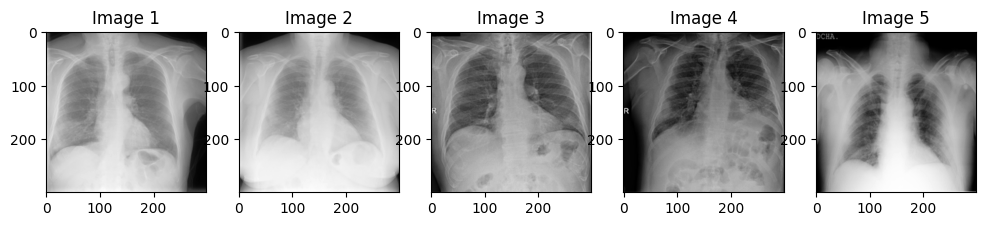

In [ ]:
show_images('COVID')

# **LUNG OPACITY**

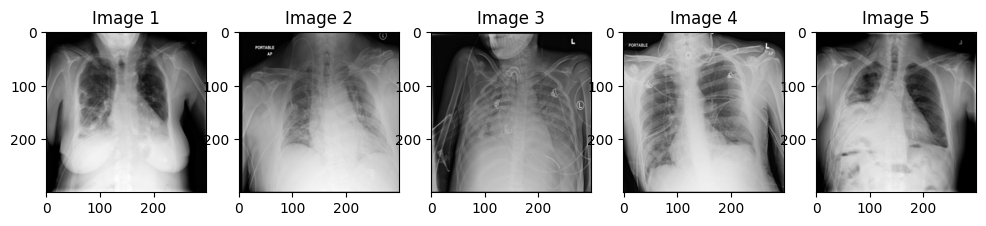

In [ ]:
show_images('Lung_Opacity')

# **NORMAL**

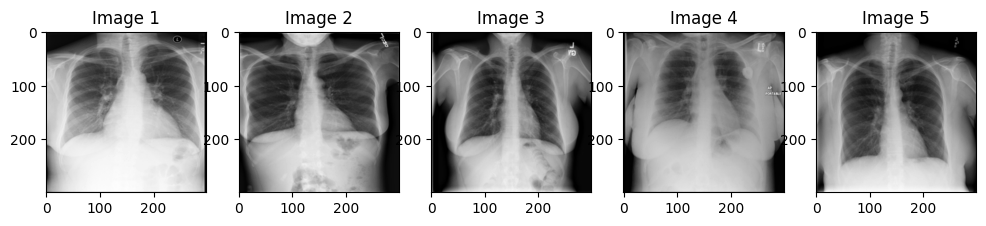

In [ ]:
show_images('Normal')

# **VIRAL PNEUMONIA**

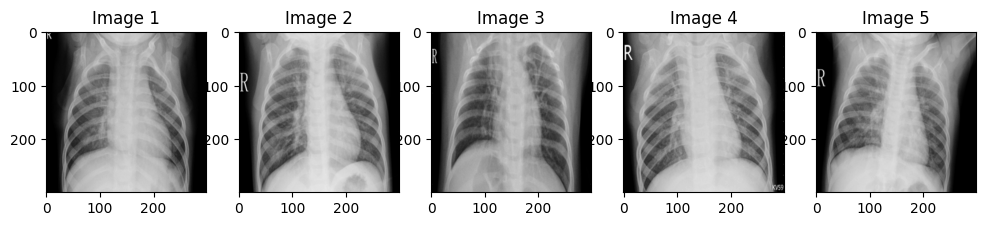

In [ ]:
show_images('Viral Pneumonia')

# **Creating the dataframe of original dataset**

In [ ]:
image_folder = 'COVID-19_Radiography_Dataset/COVID/images'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')]

df = pd.DataFrame({'File Path': image_files})
df['COVID Result'] = ["Positive"]*df.shape[0]

image_folder = 'COVID-19_Radiography_Dataset/Lung_Opacity/images'
image_files1 = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')]
image_folder = 'COVID-19_Radiography_Dataset/Normal/images'
image_files2 = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')]
image_folder = 'COVID-19_Radiography_Dataset/Viral Pneumonia/images'
image_files3 = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')]

image_result = []
image_result.extend(image_files1)
image_result.extend(image_files2)
image_result.extend(image_files3)
df1 = pd.DataFrame({'File Path': image_result})
df1['COVID Result'] = ["Negative"]*df1.shape[0]
df = pd.concat([df1,df])
df = df.sample(frac=1)
df = df.reset_index(drop=True)

df

,File Path,COVID Result
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,Negative
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,Negative
2,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Negative
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,Negative
4,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Negative
...,...,...
21160,COVID-19_Radiography_Dataset/COVID/images/COVI...,Positive
21161,COVID-19_Radiography_Dataset/COVID/images/COVI...,Positive
21162,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Negative
21163,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,Negative


In [ ]:
samples,features = df.shape
duplicated = df.duplicated().sum()
null_values = df.isnull().sum().sum()

print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Number of samples: 21165
Number of duplicated values: 0
Number of Null samples: 0


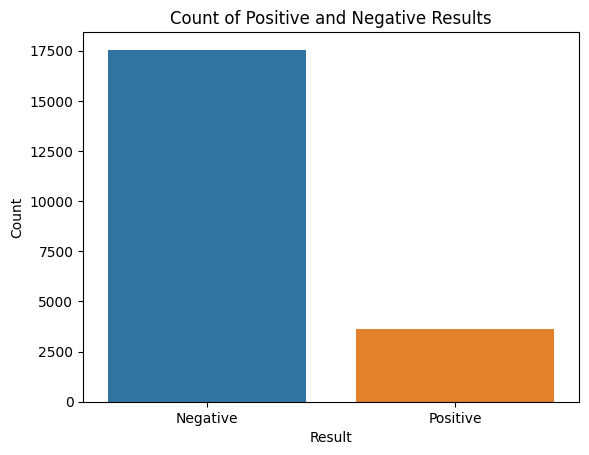

In [ ]:
sns.countplot(x='COVID Result', data=df)

plt.xlabel("Result")
plt.ylabel("Count")
plt.title("Count of Positive and Negative Results")

plt.show()

As evident from the above bar graph, the positive classes are too few as opposed to the negative class. This can pose several problems such as biasness in model, poor generalization, etc. To take care of this, image augmentaion has been applied later.

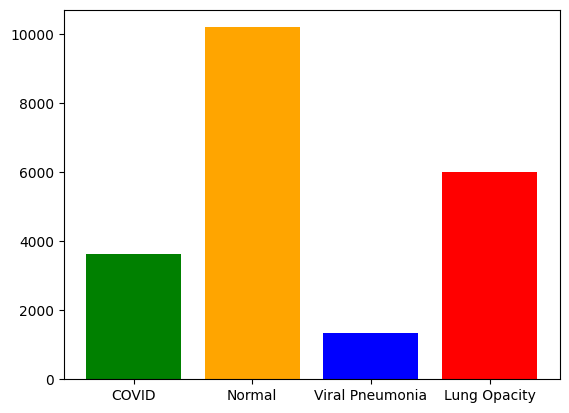

In [ ]:
covid_samples = len(os.listdir('COVID-19_Radiography_Dataset/COVID/images')) 
normal_samples = len(os.listdir('COVID-19_Radiography_Dataset/Normal/images')) 
pneu_samples = len(os.listdir('COVID-19_Radiography_Dataset/Viral Pneumonia/images')) 
lungop_samples = len(os.listdir('COVID-19_Radiography_Dataset/Lung_Opacity/images')) 

plt.bar(['COVID','Normal','Viral Pneumonia','Lung Opacity'], [covid_samples, normal_samples, pneu_samples, lungop_samples], color = ['green','orange','blue','red'])
plt.show()

In [ ]:
def random_analysis(image_path):

    image = cv2.imread(image_path)
    fig = plt.figure(figsize=(10, 7))

    fig.add_subplot(2, 3, 1)
    plt.title('Original ', fontsize = 14)
    plt.imshow(image)
    plt.axis('off')

    fig.add_subplot(2, 3, 2)
    plt.title('B channel', fontsize = 14)
    plt.imshow(image[ : , : , 0])
    plt.axis('off');

    fig.add_subplot(2, 3, 3)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    plt.title("Ben Graham's Method", fontsize = 14)
    plt.imshow(img)
    plt.axis('off')
    
    list_text = image_path.split("/")


COVID


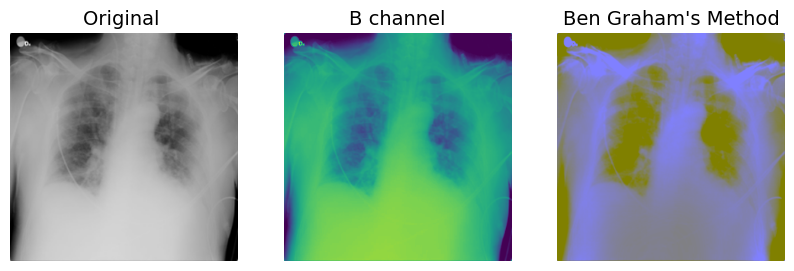

In [ ]:
print("COVID")
random_analysis('COVID-19_Radiography_Dataset/COVID/images/COVID-1.png')

NORMAL


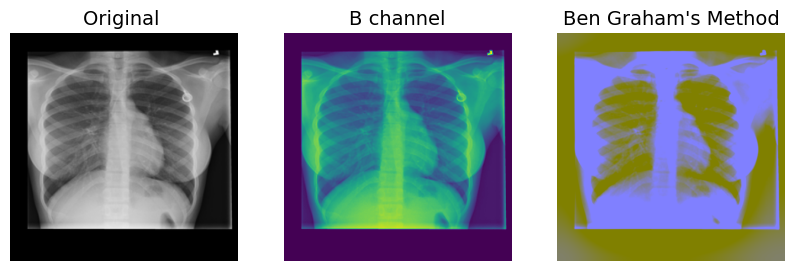

In [ ]:
print("NORMAL")
random_analysis('COVID-19_Radiography_Dataset/Normal/images/Normal-1.png')

PNEUMONIA


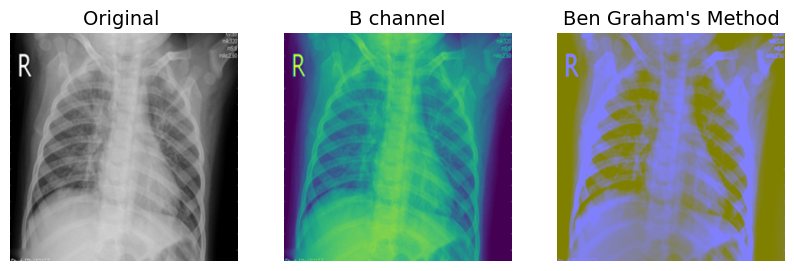

In [ ]:
print("PNEUMONIA")
random_analysis('COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1.png')

LUNG OPACITY


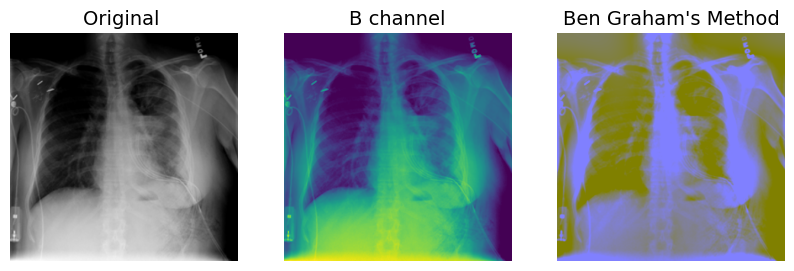

In [ ]:
print("LUNG OPACITY")
random_analysis('COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1.png')

In [ ]:
df['COVID Result'] = df['COVID Result'].apply(lambda x: 1 if x == 'Positive' else 0)
df

,File Path,COVID Result
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,0
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,0
2,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,0
4,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0
...,...,...
21160,COVID-19_Radiography_Dataset/COVID/images/COVI...,1
21161,COVID-19_Radiography_Dataset/COVID/images/COVI...,1
21162,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0
21163,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,0


# **Images with reduced resolution so as to not exceed the memory resources**

In [ ]:
df['Image'] = df['File Path'].apply(lambda x : cv2.resize(cv2.imread(x, 0), (80, 80))/255)
df

,File Path,COVID Result,Image
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.06666666666666667, 0.06274509803921569, 0...."
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.08627450980392157, 0.14901960784313725, 0...."
2,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.00392156862745098, 0.01568627450980392, 0...."
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.13725490196078433, 0.043137254901960784, 0..."
4,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.00784313725490196, 0.00784313725490196, 0...."
...,...,...,...
21160,COVID-19_Radiography_Dataset/COVID/images/COVI...,1,"[[0.011764705882352941, 0.0, 0.0, 0.0, 0.0, 0...."
21161,COVID-19_Radiography_Dataset/COVID/images/COVI...,1,"[[0.3254901960784314, 0.25098039215686274, 0.2..."
21162,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
21163,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,0,"[[0.3058823529411765, 0.3176470588235294, 0.33..."


In [ ]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0,samples):
    mean_val.append(df['Image'][i].mean())
    std_dev_val.append(np.std(df['Image'][i]))
    max_val.append(df['Image'][i].max())
    min_val.append(df['Image'][i].min())

imageEDA = df.loc[:,['Image', 'COVID Result','File Path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

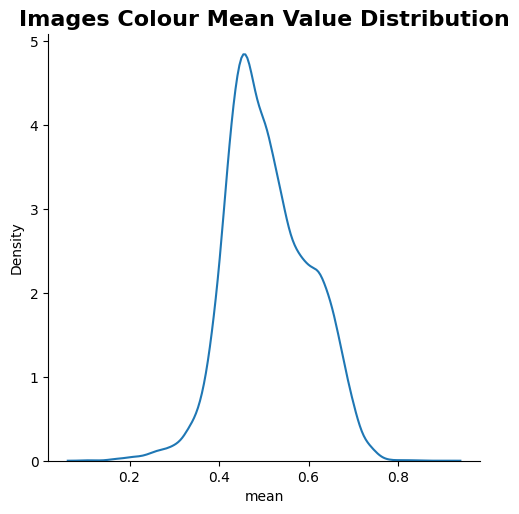

In [ ]:
sns.displot(data = imageEDA, x = 'mean', kind="kde");
plt.title('Images Colour Mean Value Distribution', fontsize = 16,weight = 'bold');

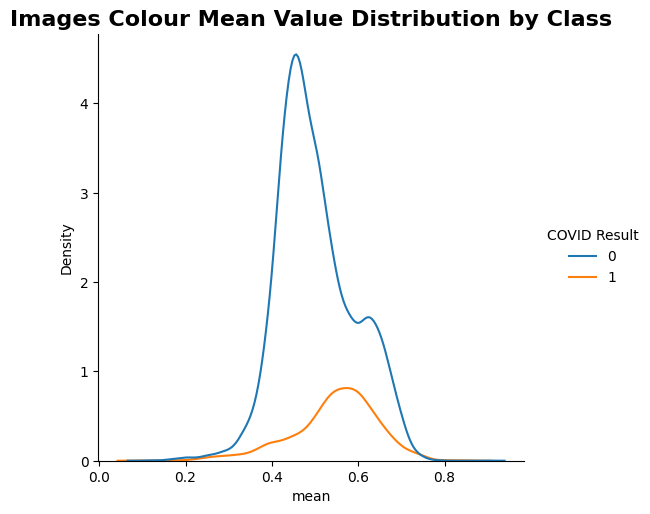

In [ ]:
sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'COVID Result');
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 16,weight = 'bold');

In [ ]:
X = list(df['Image'])
y = list(df['COVID Result'])

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state = 42)

In [ ]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
X_val = tf.convert_to_tensor(X_val)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (80, 80, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 39, 39, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 64)        0

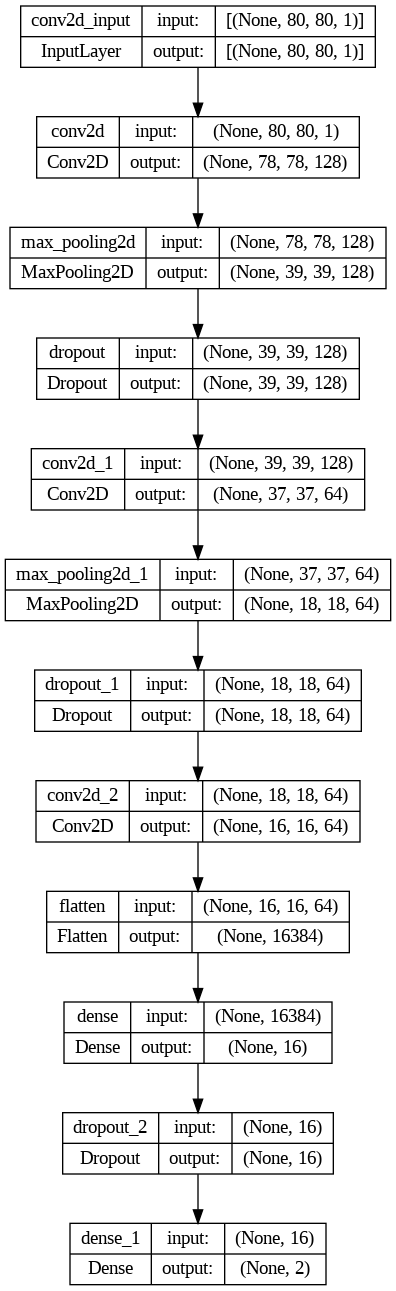

In [ ]:
plot_model(cnn_model,  show_shapes=True, show_layer_names=True)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

history = cnn_model.fit(X_train, y_train, epochs = 50, batch_size = 256,  validation_data = (X_val, y_val), callbacks = es)

Epoch 1/50
67/67 [==============================] - 23s 152ms/step - loss: 0.4705 - accuracy: 0.8283 - val_loss: 0.4211 - val_accuracy: 0.8251
Epoch 2/50
67/67 [==============================] - 9s 140ms/step - loss: 0.3758 - accuracy: 0.8296 - val_loss: 0.3425 - val_accuracy: 0.8251
Epoch 3/50
67/67 [==============================] - 9s 140ms/step - loss: 0.3185 - accuracy: 0.8296 - val_loss: 0.2949 - val_accuracy: 0.8251
Epoch 4/50
67/67 [==============================] - 9s 138ms/step - loss: 0.2876 - accuracy: 0.8635 - val_loss: 0.2769 - val_accuracy: 0.8762
Epoch 5/50
67/67 [==============================] - 10s 143ms/step - loss: 0.2671 - accuracy: 0.8910 - val_loss: 0.2538 - val_accuracy: 0.8970
Epoch 6/50
67/67 [==============================] - 10s 146ms/step - loss: 0.2500 - accuracy: 0.9062 - val_loss: 0.2416 - val_accuracy: 0.9022
Epoch 7/50
67/67 [==============================] - 9s 140ms/step - loss: 0.2301 - accuracy: 0.9150 - val_loss: 0.2224 - val_accuracy: 0.9149
Epo

In [ ]:
y_pred_train = np.argmax(cnn_model.predict(X_train), axis = 1)
y_pred_val = np.argmax(cnn_model.predict(X_val), axis = 1)
y_pred_test = np.argmax(cnn_model.predict(X_test), axis = 1)

67/67 [==============================] - 0s 5ms/step


In [ ]:
print(f"The accuracy obtained on the training data: {accuracy_score(y_train, y_pred_train)}")
print(f"The accuracy obtained on the validation data: {accuracy_score(y_val, y_pred_val)}")
print(f"The accuracy obtained on the testing data: {accuracy_score(y_test, y_pred_test)}")

The accuracy obtained on the training data: 0.9862390739428302
The accuracy obtained on the validation data: 0.9626654064272212
The accuracy obtained on the testing data: 0.9664619744922059


In [ ]:
print("Classification Report for Train Data\n")
print(classification_report(y_train, y_pred_train)) 

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14046
           1       0.94      0.98      0.96      2886

    accuracy                           0.99     16932
   macro avg       0.97      0.98      0.98     16932
weighted avg       0.99      0.99      0.99     16932



In [ ]:
print("\nClassification Report for Validation Data\n")
print(classification_report(y_val, y_pred_val))   


Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1746
           1       0.90      0.88      0.89       370

    accuracy                           0.96      2116
   macro avg       0.94      0.93      0.93      2116
weighted avg       0.96      0.96      0.96      2116



In [ ]:
print("\nClassification Report for Test Data\n")
print(classification_report(y_test, y_pred_test))  


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1757
           1       0.90      0.91      0.90       360

    accuracy                           0.97      2117
   macro avg       0.94      0.94      0.94      2117
weighted avg       0.97      0.97      0.97      2117



# **Implementing Image Augmentation to COVID class**

In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))), # blur images with a sigma between 0 and 0.5
    iaa.ContrastNormalization((0.75, 1.5)), # improve or worsen the contrast
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
    iaa.Multiply((0.8, 1.2), per_channel=0.2), # change brightness of images
    iaa.Affine(rotate=(-20, 20)), # rotate images
])


image_dir ="COVID-19_Radiography_Dataset/COVID/images"
images = []
for filename in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, filename))
    if img is not None:
        images.append(img)

for i in range(len(images)):
    image = images[i]
    image_aug = seq.augment_image(image)
    cv2.imwrite(os.path.join(image_dir, f"augmented_{i}.jpg"), image_aug)

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


**Displaying an example augmented image**

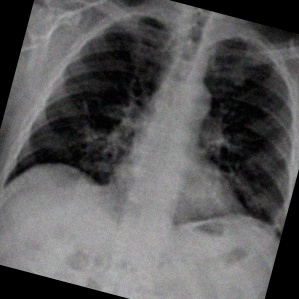

In [ ]:
from IPython.display import Image       
image_path = os.path.join(image_dir,"augmented_0.jpg")
Image(filename=image_path)

In [ ]:
image_folder = 'COVID-19_Radiography_Dataset/COVID/images'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

df2 = pd.DataFrame({'File Path': image_files})
df2['COVID Result'] = ["Positive"]*df2.shape[0]
df2

,File Path,COVID Result
0,COVID-19_Radiography_Dataset/COVID/images/augm...,Positive
1,COVID-19_Radiography_Dataset/COVID/images/augm...,Positive
2,COVID-19_Radiography_Dataset/COVID/images/COVI...,Positive
3,COVID-19_Radiography_Dataset/COVID/images/augm...,Positive
4,COVID-19_Radiography_Dataset/COVID/images/COVI...,Positive
...,...,...
7227,COVID-19_Radiography_Dataset/COVID/images/COVI...,Positive
7228,COVID-19_Radiography_Dataset/COVID/images/augm...,Positive
7229,COVID-19_Radiography_Dataset/COVID/images/COVI...,Positive
7230,COVID-19_Radiography_Dataset/COVID/images/augm...,Positive


In [ ]:
image_folder = 'COVID-19_Radiography_Dataset/Lung_Opacity/images'
image_files1 = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')]
image_folder = 'COVID-19_Radiography_Dataset/Normal/images'
image_files2 = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')]
image_folder = 'COVID-19_Radiography_Dataset/Viral Pneumonia/images'
image_files3 = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')]

image_result = []
image_result.extend(image_files1)
image_result.extend(image_files2)
image_result.extend(image_files3)
df3 = pd.DataFrame({'File Path': image_result})
df3['COVID Result'] = ["Negative"]*df3.shape[0]
df2 = pd.concat([df3,df2])
df2 = df2.sample(frac=1)
df2 = df2.reset_index(drop=True)

df2

,File Path,COVID Result
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,Negative
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,Negative
2,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Negative
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,Negative
4,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Negative
...,...,...
24776,COVID-19_Radiography_Dataset/Normal/images/Nor...,Negative
24777,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Negative
24778,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Negative
24779,COVID-19_Radiography_Dataset/COVID/images/augm...,Positive


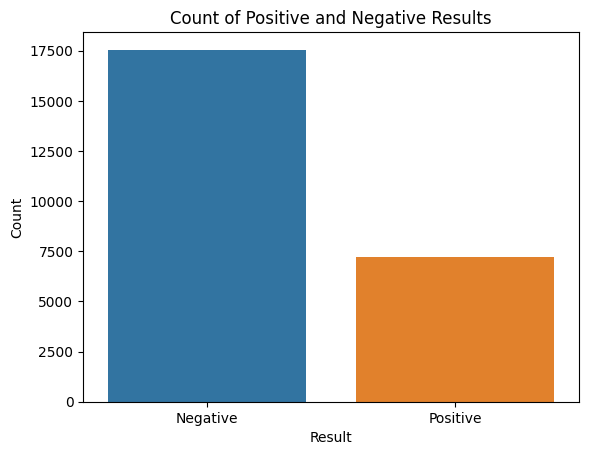

In [ ]:
sns.countplot(x='COVID Result', data=df2)

plt.xlabel("Result")
plt.ylabel("Count")
plt.title("Count of Positive and Negative Results")

plt.show()

Now the positive class is atleast a little comparable to the negative class

In [ ]:
df2['COVID Result'] = df2['COVID Result'].apply(lambda x: 1 if x == 'Positive' else 0)
df2

,File Path,COVID Result
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,0
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,0
2,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,0
4,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0
...,...,...
24776,COVID-19_Radiography_Dataset/Normal/images/Nor...,0
24777,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0
24778,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0
24779,COVID-19_Radiography_Dataset/COVID/images/augm...,1


In [ ]:
df2['Image'] = df2['File Path'].apply(lambda x : cv2.resize(cv2.imread(x, 0), (80, 80))/255)
df2

,File Path,COVID Result,Image
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.24705882352941178, 0.3333333333333333, 0.3..."
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.1450980392156863, 0.17647058823529413, 0.2..."
2,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.25882352941176473, 0.24313725490196078, 0...."
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.13725490196078433, 0.43529411764705883, 0...."
4,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.00784313725490196, 0.00784313725490196, 0...."
...,...,...,...
24776,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.0, 0.0, 0.0, 0.06274509803921569, 0.062745..."
24777,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.00392156862745098, 0.00392156862745098, 0...."
24778,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
24779,COVID-19_Radiography_Dataset/COVID/images/augm...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
X = list(df2['Image'])
y = list(df2['COVID Result'])

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state = 42)

In [ ]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
X_val = tf.convert_to_tensor(X_val)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)

In [ ]:
ann_model = models.Sequential([
    layers.Flatten(input_shape=(80, 80, 1)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2)
])

ann_model.compile(optimizer='adam', 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

ann_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               819328    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 16)               

In [ ]:
history = ann_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=50, batch_size=128)


Epoch 1/50
155/155 [==============================] - 3s 9ms/step - loss: 0.5595 - accuracy: 0.7003 - val_loss: 0.4806 - val_accuracy: 0.7031
Epoch 2/50
155/155 [==============================] - 1s 7ms/step - loss: 0.4982 - accuracy: 0.7693 - val_loss: 0.4733 - val_accuracy: 0.8233
Epoch 3/50
155/155 [==============================] - 1s 7ms/step - loss: 0.4732 - accuracy: 0.7988 - val_loss: 0.4713 - val_accuracy: 0.8415
Epoch 4/50
155/155 [==============================] - 1s 9ms/step - loss: 0.4721 - accuracy: 0.7916 - val_loss: 0.4639 - val_accuracy: 0.8233
Epoch 5/50
155/155 [==============================] - 1s 9ms/step - loss: 0.4752 - accuracy: 0.7809 - val_loss: 0.4659 - val_accuracy: 0.8386
Epoch 6/50
155/155 [==============================] - 1s 7ms/step - loss: 0.4489 - accuracy: 0.8061 - val_loss: 0.4616 - val_accuracy: 0.8411
Epoch 7/50
155/155 [==============================] - 1s 7ms/step - loss: 0.4414 - accuracy: 0.8097 - val_loss: 0.4888 - val_accuracy: 0.8306
Epoch 

In [ ]:
y_pred_train = np.argmax(ann_model.predict(X_train), axis = 1)
y_pred_val = np.argmax(ann_model.predict(X_val), axis = 1)
y_pred_test = np.argmax(ann_model.predict(X_test), axis = 1)

78/78 [==============================] - 0s 2ms/step


In [ ]:
print(f"The accuracy obtained on the training data: {accuracy_score(y_train, y_pred_train)}")
print(f"The accuracy obtained on the validation data: {accuracy_score(y_val, y_pred_val)}")
print(f"The accuracy obtained on the testing data: {accuracy_score(y_test, y_pred_test)}")

The accuracy obtained on the training data: 0.8244552058111381
The accuracy obtained on the validation data: 0.827683615819209
The accuracy obtained on the testing data: 0.8035498184751916


**As we can see, the accuracies obtained after applying the ANN model on the dataset aren't satisfactory. Therefore, we will have to resort to CNN, a more powerful and accurate classification model.**

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (80, 80, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 78, 78, 128)       1280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 39, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 39, 39, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 18, 18, 64)       

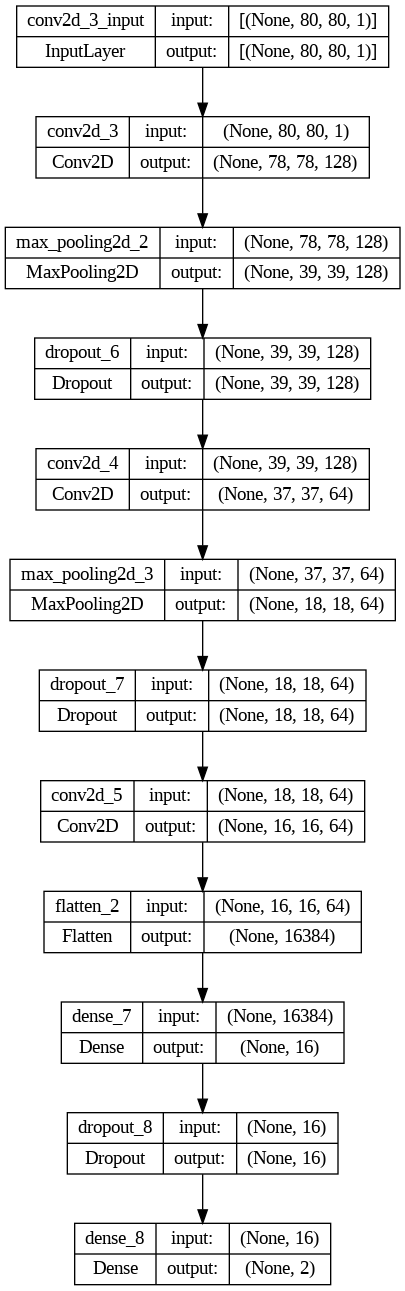

In [ ]:
plot_model(cnn_model,  show_shapes=True, show_layer_names=True)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

history = cnn_model.fit(X_train, y_train, epochs = 50, batch_size = 256,  validation_data = (X_val, y_val), callbacks = es)

Epoch 1/50
78/78 [==============================] - 15s 168ms/step - loss: 0.5850 - accuracy: 0.7033 - val_loss: 0.4641 - val_accuracy: 0.7195
Epoch 2/50
78/78 [==============================] - 11s 141ms/step - loss: 0.4468 - accuracy: 0.7630 - val_loss: 0.3678 - val_accuracy: 0.8571
Epoch 3/50
78/78 [==============================] - 11s 141ms/step - loss: 0.3711 - accuracy: 0.8679 - val_loss: 0.3343 - val_accuracy: 0.8951
Epoch 4/50
78/78 [==============================] - 11s 141ms/step - loss: 0.3382 - accuracy: 0.8844 - val_loss: 0.3080 - val_accuracy: 0.9092
Epoch 5/50
78/78 [==============================] - 11s 141ms/step - loss: 0.3146 - accuracy: 0.8962 - val_loss: 0.2975 - val_accuracy: 0.9052
Epoch 6/50
78/78 [==============================] - 11s 141ms/step - loss: 0.2910 - accuracy: 0.9074 - val_loss: 0.2778 - val_accuracy: 0.9140
Epoch 7/50
78/78 [==============================] - 11s 141ms/step - loss: 0.2709 - accuracy: 0.9132 - val_loss: 0.2347 - val_accuracy: 0.9354

In [ ]:
y_pred_train = np.argmax(cnn_model.predict(X_train), axis = 1)
y_pred_val = np.argmax(cnn_model.predict(X_val), axis = 1)
y_pred_test = np.argmax(cnn_model.predict(X_test), axis = 1)

78/78 [==============================] - 0s 6ms/step


In [ ]:
print(f"The accuracy obtained on the training data: {accuracy_score(y_train, y_pred_train)}")
print(f"The accuracy obtained on the validation data: {accuracy_score(y_val, y_pred_val)}")
print(f"The accuracy obtained on the testing data: {accuracy_score(y_test, y_pred_test)}")

The accuracy obtained on the training data: 0.9855730427764327
The accuracy obtained on the validation data: 0.9717514124293786
The accuracy obtained on the testing data: 0.9616780960064543


In [ ]:
print("Classification Report for Train Data\n")
print(classification_report(y_train, y_pred_train)) 

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14023
           1       0.98      0.97      0.98      5801

    accuracy                           0.99     19824
   macro avg       0.98      0.98      0.98     19824
weighted avg       0.99      0.99      0.99     19824



In [ ]:
print("Classification Report for Validation Data\n")
print(classification_report(y_val, y_pred_val)) 

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1783
           1       0.96      0.94      0.95       695

    accuracy                           0.97      2478
   macro avg       0.97      0.96      0.96      2478
weighted avg       0.97      0.97      0.97      2478



In [ ]:
print("Classification Report for Testing Data\n")
print(classification_report(y_test, y_pred_test)) 

Classification Report for Testing Data

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1743
           1       0.95      0.92      0.93       736

    accuracy                           0.96      2479
   macro avg       0.96      0.95      0.95      2479
weighted avg       0.96      0.96      0.96      2479



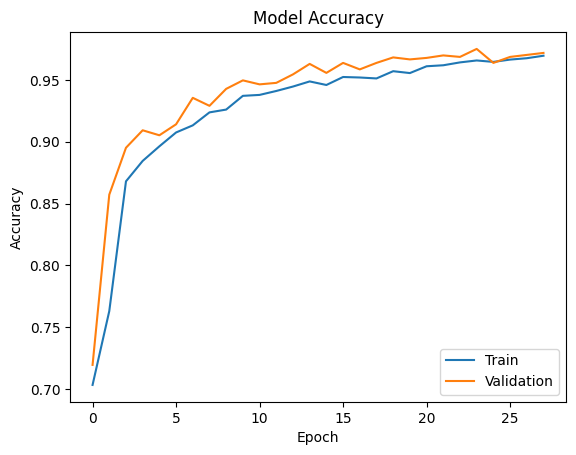

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

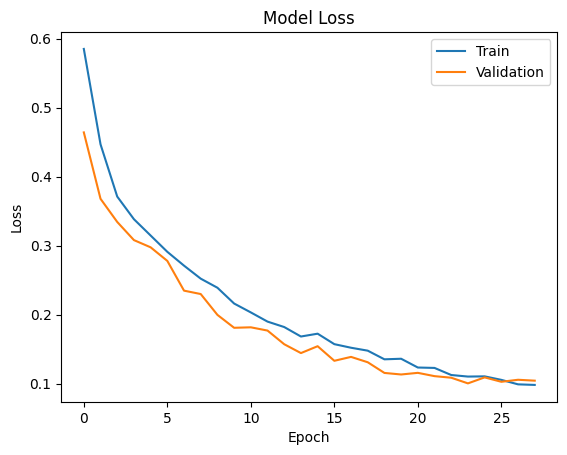

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

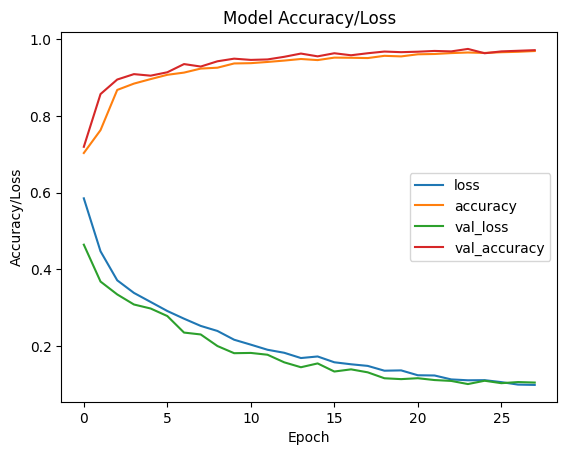

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

# **GRAD-CAM Visualization**

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

In [ ]:
import tensorflow

In [ ]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# To Get Image into numpy array
def get_img_array(img_path, size):
    img = tensorflow.keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = tensorflow.keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
list_images_sample = ["COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1003.png",
                     "COVID-19_Radiography_Dataset/Normal/images/Normal-1004.png",
                     "COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1000.png",
                     "COVID-19_Radiography_Dataset/COVID/images/COVID-1008.png"]

In [ ]:
# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 705ms/step


In [ ]:
# To Display GradCAM output for the samples

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = tensorflow.keras.preprocessing.image.load_img(img_path)
    img = tensorflow.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tensorflow.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tensorflow.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tensorflow.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])

<ipython-input-66-7568ce245535>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [ ]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

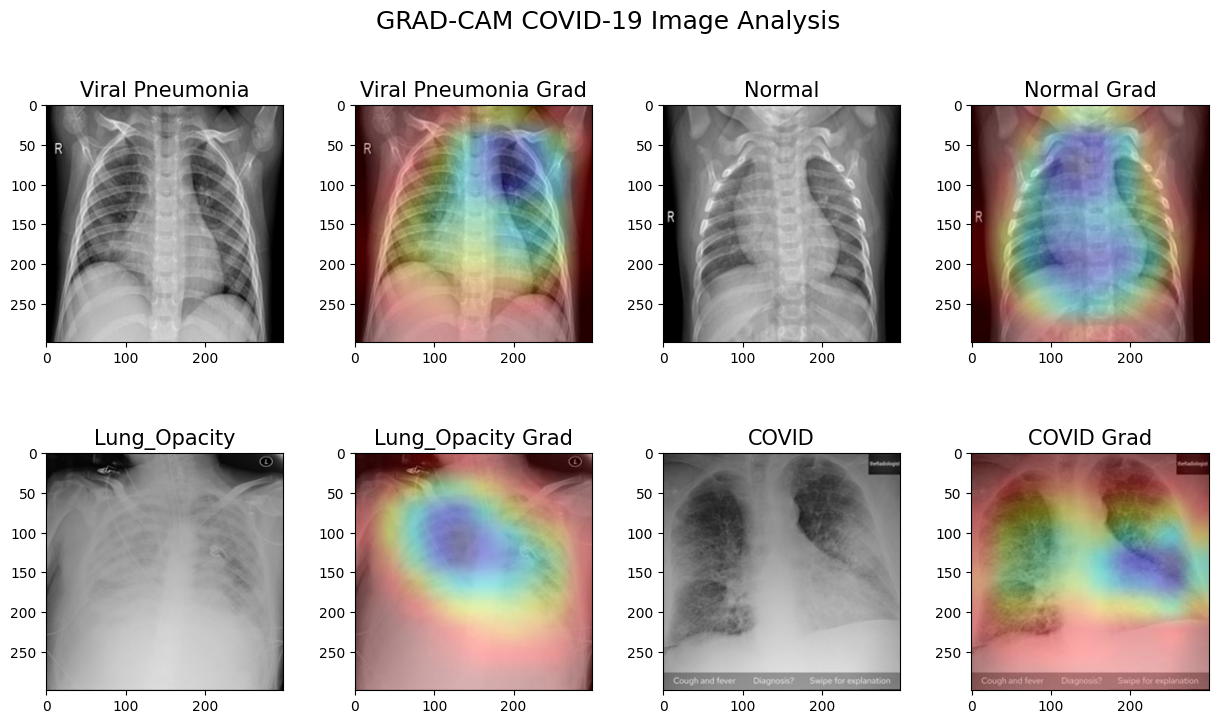

In [ ]:
titles_list = ["Viral Pneumonia",'Viral Pneumonia Grad','Normal','Normal Grad','Lung_Opacity','Lung_Opacity Grad','COVID','COVID Grad']

plot_multiple_img(imag, titles_list, ncols = 4, main_title = "GRAD-CAM COVID-19 Image Analysis")

# Now, classifying the X-Ray into a specific disease. 

In [ ]:
label_dict = {'NORMAL': 0,'COVID': 1, 'PNEUMONIA': 2, 'LUNG_OPACITY': 3}

covid_dir_path = 'COVID-19_Radiography_Dataset/COVID/images'
normal_dir_path = 'COVID-19_Radiography_Dataset/Normal/images'
pneu_dir_path = 'COVID-19_Radiography_Dataset/Viral Pneumonia/images'
lungop_dir_path = 'COVID-19_Radiography_Dataset/Lung_Opacity/images'

def get_label(image_path):
    if os.path.dirname(image_path) == normal_dir_path:
      return 0
    elif os.path.dirname(image_path) == covid_dir_path:
      return 1
    elif os.path.dirname(image_path) == pneu_dir_path:
      return 2
    else:
      return 3

df2['Disease'] = df2['File Path'].apply(lambda x: get_label(x))
df2

,File Path,COVID Result,Image,Disease
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.24705882352941178, 0.3333333333333333, 0.3...",0
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.1450980392156863, 0.17647058823529413, 0.2...",0
2,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.25882352941176473, 0.24313725490196078, 0....",3
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.13725490196078433, 0.43529411764705883, 0....",0
4,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.00784313725490196, 0.00784313725490196, 0....",3
...,...,...,...,...
24776,COVID-19_Radiography_Dataset/Normal/images/Nor...,0,"[[0.0, 0.0, 0.0, 0.06274509803921569, 0.062745...",0
24777,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.00392156862745098, 0.00392156862745098, 0....",3
24778,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
24779,COVID-19_Radiography_Dataset/COVID/images/augm...,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [ ]:
X2 = list(df2['Image'])
y2 = list(df2['Disease'])

X2_train, X2_rem, y2_train, y2_rem = train_test_split(X2,y2, train_size=0.8, random_state = 42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_rem,y2_rem, test_size=0.5, random_state = 42)

In [ ]:
X2_train = tf.convert_to_tensor(X2_train)
X2_test = tf.convert_to_tensor(X2_test)
X2_val = tf.convert_to_tensor(X2_val)
y2_train = tf.convert_to_tensor(y2_train)
y2_test = tf.convert_to_tensor(y2_test)
y2_val = tf.convert_to_tensor(y2_val)

In [ ]:
cnn_model2 = models.Sequential()
cnn_model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (80, 80, 1)))
cnn_model2.add(layers.MaxPooling2D((2, 2)))
cnn_model2.add(layers.Dropout(0.3))

cnn_model2.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model2.add(layers.MaxPooling2D((2, 2)))
cnn_model2.add(layers.Dropout(0.5))

cnn_model2.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model2.add(layers.Flatten())
cnn_model2.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model2.add(layers.Dropout(0.2))

cnn_model2.add(layers.Dense(units = 4))

cnn_model2.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 78, 78, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 39, 39, 128)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 39, 39, 128)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 37, 37, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 18, 18, 64)       

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

history = cnn_model2.fit(X2_train, y2_train, epochs = 50, batch_size = 256,  validation_data = (X2_val, y2_val), callbacks = es)

Epoch 1/50
78/78 [==============================] - 13s 145ms/step - loss: 1.0818 - accuracy: 0.4882 - val_loss: 0.8758 - val_accuracy: 0.6590
Epoch 2/50
78/78 [==============================] - 11s 142ms/step - loss: 0.8412 - accuracy: 0.6387 - val_loss: 0.6800 - val_accuracy: 0.7345
Epoch 3/50
78/78 [==============================] - 11s 142ms/step - loss: 0.7381 - accuracy: 0.6853 - val_loss: 0.5874 - val_accuracy: 0.7978
Epoch 4/50
78/78 [==============================] - 11s 143ms/step - loss: 0.6726 - accuracy: 0.7351 - val_loss: 0.5415 - val_accuracy: 0.8095
Epoch 5/50
78/78 [==============================] - 11s 141ms/step - loss: 0.6355 - accuracy: 0.7527 - val_loss: 0.5052 - val_accuracy: 0.8184
Epoch 6/50
78/78 [==============================] - 11s 140ms/step - loss: 0.6144 - accuracy: 0.7609 - val_loss: 0.4750 - val_accuracy: 0.8394
Epoch 7/50
78/78 [==============================] - 11s 141ms/step - loss: 0.5843 - accuracy: 0.7767 - val_loss: 0.4640 - val_accuracy: 0.8523

In [ ]:
y_pred_train2 = np.argmax(cnn_model2.predict(X2_train), axis = 1)
y_pred_val2 = np.argmax(cnn_model2.predict(X2_val), axis = 1)
y_pred_test2 = np.argmax(cnn_model2.predict(X2_test), axis = 1)

In [ ]:
print(f"The accuracy obtained on the training data: {accuracy_score(y2_train, y_pred_train2)}")
print(f"The accuracy obtained on the validation data: {accuracy_score(y2_val, y_pred_val2)}")
print(f"The accuracy obtained on the testing data: {accuracy_score(y2_test, y_pred_test2)}")

In [ ]:
print("Classification Report for Train Data\n")
print(classification_report(y2_train, y_pred_train2)) 

In [ ]:
print("\nClassification Report for Validation Data\n")
print(classification_report(y2_val, y_pred_val2))   

In [ ]:
print("\nClassification Report for Testing Data\n")
print(classification_report(y2_test, y_pred_test2))   

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

In [ ]:
pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

# **The following code saves the model in a .pkl format to be used for embedding it on a webpage**

In [ ]:
import pickle
pickle.dump(cnn_model, open('model.pkl', 'wb'))

model = pickle.load(open('model.pkl','rb'))